In [1]:
# torch==1.5.1. torch vision==0.6.1
import models
# import datas

import argparse
import torch

import torchvision.transforms as TF
import torch.nn as nn
import time
import os
from math import log10
from utils.config import Config
import sys

import time

import cv2
from PIL import Image
import glob
import multiprocessing as mp
import math
import numpy as np

In [2]:
mean = [0.429, 0.431, 0.397]
mean = [0.429, 0.429, 0.429]# for gray scale
std  = [1, 1, 1]

inter_frames = 3


modelname = 'QVI'
pwc_path = './utils/network-default.pytorch'


store_path = 'outputs/example/'
checkpoint = 'checkpoints/quadratic/model.ckpt'

# preparing datasets
normalize1 = TF.Normalize(mean, [1.0, 1.0, 1.0])
normalize2 = TF.Normalize([0, 0, 0], std)
trans = TF.Compose([TF.ToTensor(), normalize1, normalize2, ])

revmean = [-x for x in mean]
revstd = [1.0 / x for x in std]
revnormalize1 = TF.Normalize([0.0, 0.0, 0.0], revstd)
revnormalize2 = TF.Normalize(revmean, [1.0, 1.0, 1.0])
revNormalize = TF.Compose([revnormalize1, revnormalize2])

revtrans = TF.Compose([revnormalize1, revnormalize2, TF.ToPILImage()])

In [3]:
#testset = datas.AIMSequence(config.testset_root, trans, config.test_size, config.test_crop_size, config.inter_frames)
#sampler = torch.utils.data.SequentialSampler(testset)
#validationloader = torch.utils.data.DataLoader(testset, sampler=sampler, batch_size=1, shuffle=False, num_workers=1)

# model
import time
starttime = time.time()
model = getattr(models, modelname)(pwc_path).cuda()
print("loadtime, {}s".format(time.time()-starttime))
starttime = time.time()
model = nn.DataParallel(model)
print("paratime, {}s".format(time.time()-starttime))

tot_time = 0
tot_frames = 0

loadtime, 2.8235044479370117s
paratime, 0.012783288955688477s


/home/runqiu/.local/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [4]:
print('Everything prepared. Ready to test...')
def pil_imread(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

Everything prepared. Ready to test...


In [5]:
dict1 = torch.load(checkpoint)
model.load_state_dict(dict1['model_state_dict'])
print("success load model")

success load model


In [6]:
data_path = '/media/runqiu/data/davis240c/train/boxes_6dof/images'
store_path = '/media/runqiu/data/davis240c/train/boxes_6dof/images_4x'

In [8]:
src_file_style = 'frame_%08d.png'
os.makedirs(store_path, exist_ok = True)
img_file = sorted(os.listdir(data_path))
start_idx = 0
n_process = 8
store_num = 500
print(len(img_file))

#--------processing--------
start = time.time()
out_imgs = []
frame_numbias = 1
i = 1
img_0 = pil_imread(data_path+"/"+(src_file_style %(i-1)))
img_1 = pil_imread(data_path+"/"+(src_file_style %(i)))
img_2 = pil_imread(data_path+"/"+(src_file_style %(i+1)))
img_3 = pil_imread(data_path+"/"+(src_file_style %(i+2)))

img_0 = trans(img_0).unsqueeze(0)
img_1 = trans(img_1).unsqueeze(0)
img_2 = trans(img_2).unsqueeze(0)
img_3 = trans(img_3).unsqueeze(0)

I0 = img_0.cuda()
I1 = img_1.cuda()
I2 = img_2.cuda()
I3 = img_3.cuda()

1298


In [9]:
print(torch.backends.cudnn.version())
print(torch.version.cuda)

8005
11.1


In [10]:
out_imgs.append(img_1[0])
with torch.no_grad():
    for tt in range(inter_frames):
        x = inter_frames
        t = 1.0/(x+1) * (tt + 1)
        # print(t)

        # record duration time
        start_time = time.time()

        output = model(I0, I1, I2, I3, t)
        print("one image cost {} s".format(time.time()-start_time))
        It_warp = output
        It_warp = It_warp.cpu()[0]
        out_imgs.append(It_warp)

/home/runqiu/.local/lib/python3.8/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


one image cost 1.2047898769378662 s
one image cost 0.0587313175201416 s
one image cost 0.05739593505859375 s


/home/runqiu/.local/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [15]:
len(out_imgs)

4

In [11]:
def pil_imwrite(path, img):
    img.save(path)

True

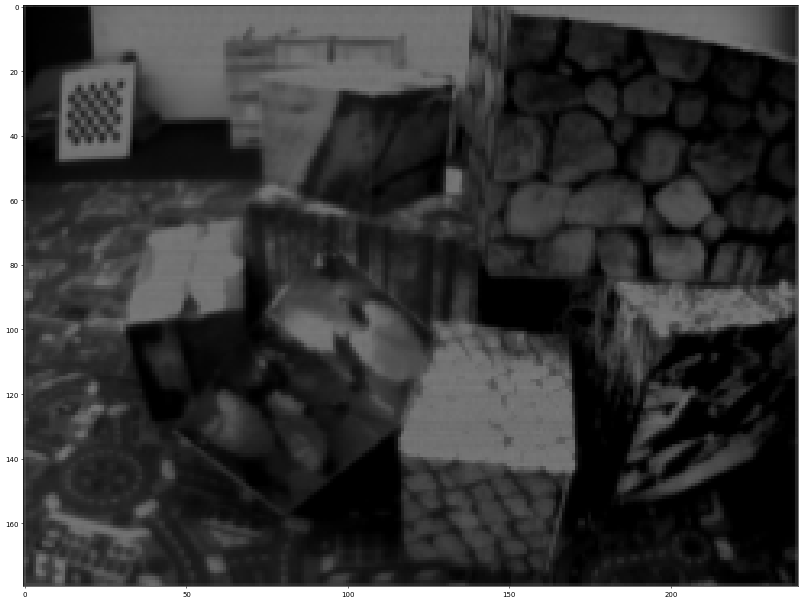

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20), dpi=50)
plt.imshow(np.asarray(revtrans(out_imgs[1])))
cv2.imwrite('test2.png', np.asarray(revtrans(out_imgs[0]).convert('L')))

In [8]:
start = time.time()
a = torch.randn((1000, 1000, 1000)).float().cuda()
print("time cost {} s".format(time.time()-start))

time cost 7.397439479827881 s
